In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tensorflow



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


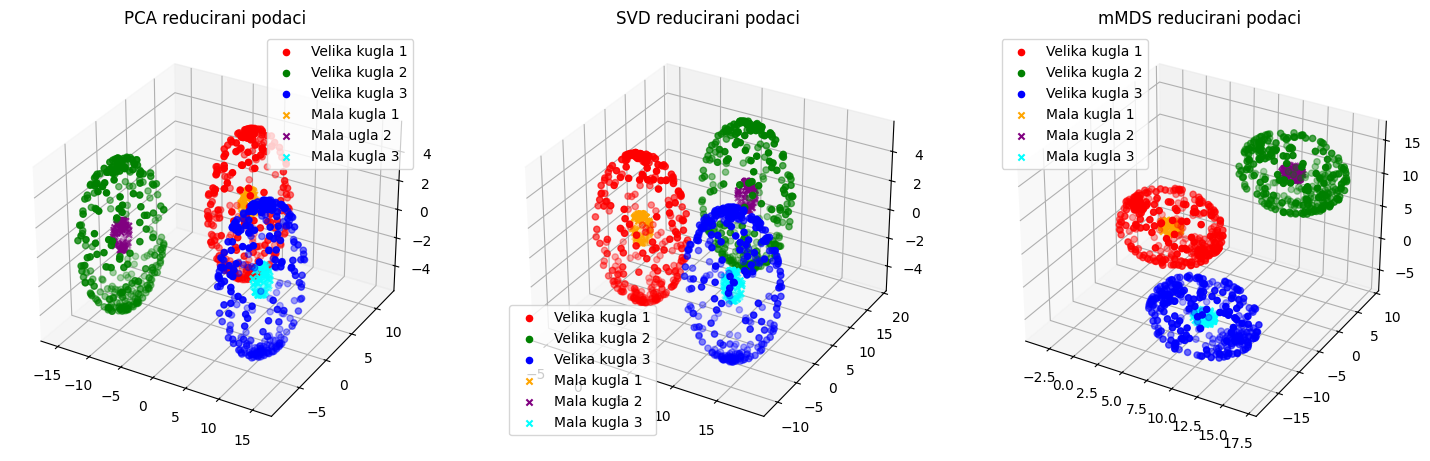

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD

# Funkcija za generiranje kugli
def generate_spheres(n, radius=1):
    phi = np.random.uniform(0, 2 * np.pi, n)
    theta = np.random.uniform(0, np.pi, n)
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return np.vstack((x, y, z)).T

n = 300

K1 = generate_spheres(n, radius=5) + np.array([0, 0, 0])
K2 = generate_spheres(n, radius=5) + np.array([15, 0, 0])
K3 = generate_spheres(n, radius=5) + np.array([0, 15, 0])
K1_small = generate_spheres(n//3, radius=1) + np.array([0, 0, 0])
K2_small = generate_spheres(n//3, radius=1) + np.array([15, 0, 0])
K3_small = generate_spheres(n//3, radius=1) + np.array([0, 15, 0])
data = np.vstack((K1, K2, K3, K1_small, K2_small, K3_small))

class MDSNet(tf.keras.Model):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(MDSNet, self).__init__()
        self.hidden_layers = []
        for hidden_dim in hidden_dims:
            self.hidden_layers.append(
                tf.keras.layers.Dense(hidden_dim, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))
            )
            self.hidden_layers.append(tf.keras.layers.Dropout(0.2))
        self.output_layer = tf.keras.layers.Dense(output_dim, activation=None)
    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)


def pairwise_distances(x):
    dot_product = tf.matmul(x, tf.transpose(x))
    square_norm = tf.linalg.diag_part(dot_product)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)
    distances = tf.sqrt(tf.maximum(distances, 1e-9)) 
    return distances


input_dim = data.shape[1]
hidden_dims = [128, 64, 32]  
output_dim = 3


model_mmds = MDSNet(input_dim, hidden_dims, output_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(batch_data):
    with tf.GradientTape() as tape:
        output = model_mmds(batch_data)
        distance_orig = pairwise_distances(batch_data)
        distance_proj = pairwise_distances(output)
        loss = tf.reduce_mean(tf.square(distance_proj - distance_orig))
    gradients = tape.gradient(loss, model_mmds.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_mmds.trainable_variables))
    return loss

data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
epochs = 3000
batch_size = 32

for epoch in range(epochs):
    permutation = np.random.permutation(data.shape[0])
    for i in range(0, data.shape[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_data = tf.gather(data_tensor, indices)
        loss = train_step(batch_data)

output_data = model_mmds(data_tensor).numpy()

pca = PCA(n_components=3)
data_pca = pca.fit_transform(data)

svd = TruncatedSVD(n_components=3)
data_svd = svd.fit_transform(data)

fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(data_pca[:n, 0], data_pca[:n, 1], data_pca[:n, 2], color='red', marker='o', label='Velika kugla 1')
ax1.scatter(data_pca[n:2*n, 0], data_pca[n:2*n, 1], data_pca[n:2*n, 2], color='green', marker='o', label='Velika kugla 2')
ax1.scatter(data_pca[2*n:3*n, 0], data_pca[2*n:3*n, 1], data_pca[2*n:3*n, 2], color='blue', marker='o', label='Velika kugla 3')
ax1.scatter(data_pca[3*n:3*n + n//3, 0], data_pca[3*n:3*n + n//3, 1], data_pca[3*n:3*n + n//3, 2], color='orange', marker='x', label='Mala kugla 1')
ax1.scatter(data_pca[3*n + n//3:3*n + 2*(n//3), 0], data_pca[3*n + n//3:3*n + 2*(n//3), 1], data_pca[3*n + n//3:3*n + 2*(n//3), 2], color='purple', marker='x', label='Mala ugla 2')
ax1.scatter(data_pca[3*n + 2*(n//3):, 0], data_pca[3*n + 2*(n//3):, 1], data_pca[3*n + 2*(n//3):, 2], color='cyan', marker='x', label='Mala kugla 3')
ax1.legend()
ax1.set_title('PCA reducirani podaci')

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(data_svd[:n, 0], data_svd[:n, 1], data_svd[:n, 2], color='red', marker='o', label='Velika kugla 1')
ax2.scatter(data_svd[n:2*n, 0], data_svd[n:2*n, 1], data_svd[n:2*n, 2], color='green', marker='o', label='Velika kugla 2')
ax2.scatter(data_svd[2*n:3*n, 0], data_svd[2*n:3*n, 1], data_svd[2*n:3*n, 2], color='blue', marker='o', label='Velika kugla 3')
ax2.scatter(data_svd[3*n:3*n + n//3, 0], data_svd[3*n:3*n + n//3, 1], data_svd[3*n:3*n + n//3, 2], color='orange', marker='x', label='Mala kugla 1')
ax2.scatter(data_svd[3*n + n//3:3*n + 2*(n//3), 0], data_svd[3*n + n//3:3*n + 2*(n//3), 1], data_svd[3*n + n//3:3*n + 2*(n//3), 2], color='purple', marker='x', label='Mala kugla 2')
ax2.scatter(data_svd[3*n + 2*(n//3):, 0], data_svd[3*n + 2*(n//3):, 1], data_svd[3*n + 2*(n//3):, 2], color='cyan', marker='x', label='Mala kugla 3')
ax2.legend()
ax2.set_title('SVD reducirani podaci')

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(output_data[:n, 0], output_data[:n, 1], output_data[:n, 2], color='red', marker='o', label='Velika kugla 1')
ax3.scatter(output_data[n:2*n, 0], output_data[n:2*n, 1], output_data[n:2*n, 2], color='green', marker='o', label='Velika kugla 2')
ax3.scatter(output_data[2*n:3*n, 0], output_data[2*n:3*n, 1], output_data[2*n:3*n, 2], color='blue', marker='o', label='Velika kugla 3')
ax3.scatter(output_data[3*n:3*n + n//3, 0], output_data[3*n:3*n + n//3, 1], output_data[3*n:3*n + n//3, 2], color='orange', marker='x', label='Mala kugla 1')
ax3.scatter(output_data[3*n + n//3:3*n + 2*(n//3), 0], output_data[3*n + n//3:3*n + 2*(n//3), 1], output_data[3*n + n//3:3*n + 2*(n//3), 2], color='purple', marker='x', label='Mala kugla 2')
ax3.scatter(output_data[3*n + 2*(n//3):, 0], output_data[3*n + 2*(n//3):, 1], output_data[3*n + 2*(n//3):, 2], color='cyan', marker='x', label='Mala kugla 3')
ax3.legend()
ax3.set_title('mMDS reducirani podaci')
plt.show()

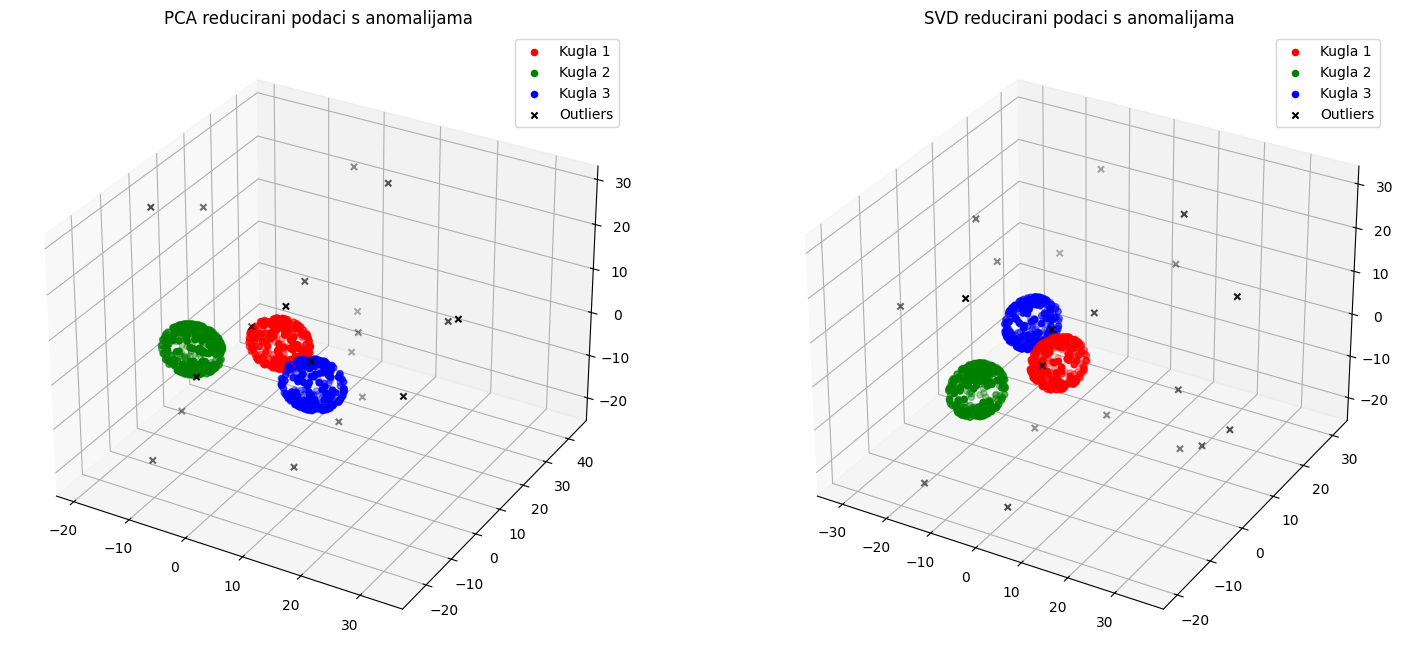

In [7]:
# Dodavanje anomalija (outliers)
num_outliers = 20
outliers = np.random.uniform(-30, 30, (num_outliers, 3))

data_with_outliers = np.vstack((K1, K2, K3, outliers))

pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_with_outliers)


svd = TruncatedSVD(n_components=3)
data_svd = svd.fit_transform(data_with_outliers)

fig = plt.figure(figsize=(18, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(data_pca[:n, 0], data_pca[:n, 1], data_pca[:n, 2], color='red', marker='o', label='Kugla 1')
ax1.scatter(data_pca[n:2*n, 0], data_pca[n:2*n, 1], data_pca[n:2*n, 2], color='green', marker='o', label='Kugla 2')
ax1.scatter(data_pca[2*n:3*n, 0], data_pca[2*n:3*n, 1], data_pca[2*n:3*n, 2], color='blue', marker='o', label='Kugla 3')
ax1.scatter(data_pca[3*n:, 0], data_pca[3*n:, 1], data_pca[3*n:, 2], color='black', marker='x', label='Outliers')
ax1.legend()
ax1.set_title('PCA reducirani podaci s anomalijama')


ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(data_svd[:n, 0], data_svd[:n, 1], data_svd[:n, 2], color='red', marker='o', label='Kugla 1')
ax2.scatter(data_svd[n:2*n, 0], data_svd[n:2*n, 1], data_svd[n:2*n, 2], color='green', marker='o', label='Kugla 2')
ax2.scatter(data_svd[2*n:3*n, 0], data_svd[2*n:3*n, 1], data_svd[2*n:3*n, 2], color='blue', marker='o', label='Kugla 3')
ax2.scatter(data_svd[3*n:, 0], data_svd[3*n:, 1], data_svd[3*n:, 2], color='black', marker='x', label='Outliers')
ax2.legend()
ax2.set_title('SVD reducirani podaci s anomalijama')

plt.show()


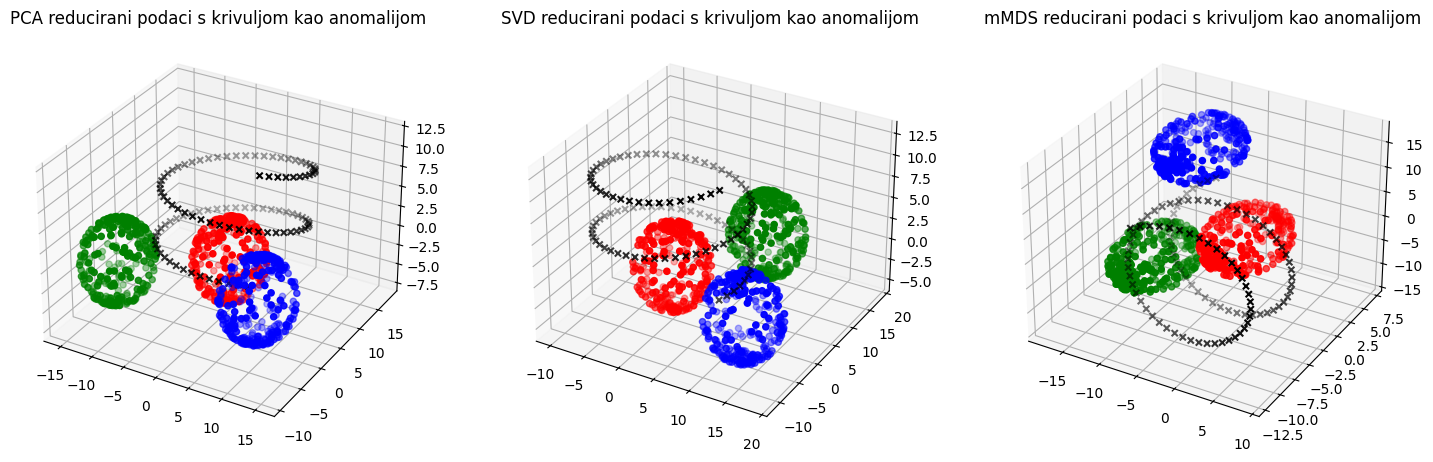

In [8]:
# Generiranje sinusoidne krivulje kao anomalije
t = np.linspace(0, 4 * np.pi, 100)  
x_curve = 10 * np.sin(t)
y_curve = 10 * np.cos(t)
z_curve = t
curve = np.vstack((x_curve, y_curve, z_curve)).T

data_with_curve = np.vstack((K1, K2, K3, curve))

pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_with_curve)


svd = TruncatedSVD(n_components=3)
data_svd = svd.fit_transform(data_with_curve)

# mMDS implementacija
class MDSNet(tf.keras.Model):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(MDSNet, self).__init__()
        self.hidden_layers = []
        
        for hidden_dim in hidden_dims:
            self.hidden_layers.append(
                tf.keras.layers.Dense(hidden_dim, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))
            )
            self.hidden_layers.append(tf.keras.layers.Dropout(0.2))
        
        self.output_layer = tf.keras.layers.Dense(output_dim, activation=None)
    
    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        
        return self.output_layer(x)


def pairwise_distances(x):
    dot_product = tf.matmul(x, tf.transpose(x))
    square_norm = tf.linalg.diag_part(dot_product)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)
    distances = tf.sqrt(tf.maximum(distances, 1e-9)) 
    return distances

input_dim = data_with_curve.shape[1]
hidden_dims = [128, 64, 32]  
output_dim = 3

model_mmds = MDSNet(input_dim, hidden_dims, output_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(batch_data):
    with tf.GradientTape() as tape:
        output = model_mmds(batch_data)
        distance_orig = pairwise_distances(batch_data)
        distance_proj = pairwise_distances(output)
        loss = tf.reduce_mean(tf.square(distance_proj - distance_orig))
    gradients = tape.gradient(loss, model_mmds.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_mmds.trainable_variables))
    return loss

data_tensor = tf.convert_to_tensor(data_with_curve, dtype=tf.float32)
epochs = 3000
batch_size = 32

for epoch in range(epochs):
    permutation = np.random.permutation(data_with_curve.shape[0])
    for i in range(0, data_with_curve.shape[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_data = tf.gather(data_tensor, indices)
        loss = train_step(batch_data)

output_data = model_mmds(data_tensor).numpy()

fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(data_pca[:n, 0], data_pca[:n, 1], data_pca[:n, 2], color='red', marker='o')
ax1.scatter(data_pca[n:2*n, 0], data_pca[n:2*n, 1], data_pca[n:2*n, 2], color='green', marker='o')
ax1.scatter(data_pca[2*n:3*n, 0], data_pca[2*n:3*n, 1], data_pca[2*n:3*n, 2], color='blue', marker='o')
ax1.scatter(data_pca[3*n:, 0], data_pca[3*n:, 1], data_pca[3*n:, 2], color='black', marker='x')
ax1.set_title('PCA reducirani podaci s krivuljom kao anomalijom')

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(data_svd[:n, 0], data_svd[:n, 1], data_svd[:n, 2], color='red', marker='o')
ax2.scatter(data_svd[n:2*n, 0], data_svd[n:2*n, 1], data_svd[n:2*n, 2], color='green', marker='o',)
ax2.scatter(data_svd[2*n:3*n, 0], data_svd[2*n:3*n, 1], data_svd[2*n:3*n, 2], color='blue', marker='o')
ax2.scatter(data_svd[3*n:, 0], data_svd[3*n:, 1], data_svd[3*n:, 2], color='black', marker='x')
ax2.set_title('SVD reducirani podaci s krivuljom kao anomalijom')

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(output_data[:n, 0], output_data[:n, 1], output_data[:n, 2], color='red', marker='o')
ax3.scatter(output_data[n:2*n, 0], output_data[n:2*n, 1], output_data[n:2*n, 2], color='green', marker='o')
ax3.scatter(output_data[2*n:3*n, 0], output_data[2*n:3*n, 1], output_data[2*n:3*n, 2], color='blue', marker='o')
ax3.scatter(output_data[3*n:, 0], output_data[3*n:, 1], output_data[3*n:, 2], color='black', marker='x')
ax3.set_title('mMDS reducirani podaci s krivuljom kao anomalijom')
plt.show()